In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from xgcm import Grid
from backgroung import plot_map

%matplotlib inline

In [3]:
model_path = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'
model = xr.open_dataset(model_path)

In [4]:
model.coords

Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 -0.8833 -0.85 -0.8167 ...
  * s_w         (s_w) float64 -1.0 -0.9667 -0.9333 -0.9 -0.8667 -0.8333 -0.8 ...
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
    lon_u       (eta_u, xi_u) float64 ...
    lat_u       (eta_u, xi_u) float64 ...
    lon_v       (eta_v, xi_v) float64 ...
    lat_v       (eta_v, xi_v) float64 ...
    lon_psi     (eta_psi, xi_psi) float64 ...
    lat_psi     (eta_psi, xi_psi) float64 ...
  * ocean_time  (ocean_time) datetime64[ns] 1993-01-01T01:00:00 ...

XGCM Axes and Positions
<img src='axis_positions.svg'>

ROMS GRID
<img src='Whole_grid.png'>

In [5]:
rename_dict = {'xi_v':'xi_rho', 'xi_psi':'xi_u', 'eta_u':'eta_rho', 'eta_psi':'eta_v'}

def rename_redundant_dim(ds, rename_dict):
    for k,v in rename_dict.items():
        ds_full = ds.copy()
        # remove redundant dims
        drop_vars = [a for a in ds.keys() if k in ds[a].dims]
        ds = ds.drop(drop_vars)
        for d in ds_full.data_vars:
            if k in ds_full[d].dims:
                ds[d] = ds_full[d].rename({k:v})
        for c in ds_full.coords:
            if k in ds_full[c].dims:
                ds.coords[c] = ds_full[c].rename({k:v})
    return ds

model = rename_redundant_dim(model, rename_dict);

/Users/vrx/miniconda3/envs/owl/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


In [7]:
model['u']

<xarray.DataArray 'xi_rho' (xi_rho: 671)>
array([  0,   1,   2, ..., 668, 669, 670])
Dimensions without coordinates: xi_rho

In [8]:
coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
        'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
        's':{'center':'s_rho', 'outer':'s_w'}}
grid = Grid(model, coords=coords)

In [9]:
grid

<xgcm.Grid>
xi Axis (periodic):
  * center   xi_rho (671) --> inner
  * inner    xi_u (670) --> center
eta Axis (periodic):
  * center   eta_rho (191) --> inner
  * inner    eta_v (190) --> center
s Axis (periodic):
  * center   s_rho (30) --> outer
  * outer    s_w (31) --> center

In [12]:
grid.diff(ds['u'], 'eta').dims

('eta_v', 'xi_u')

Core Grid Operations: diff, interp, and cumsum

In [10]:
ds = model.sel(ocean_time='2010-08-01-T00').isel(s_rho=-1)

In [13]:
dudy = grid.diff(ds['u'], 'eta')*grid.interp(grid.interp(ds['pn'], 'eta'), 'xi')
dvdx = grid.diff(ds['v'], 'xi')*grid.interp(grid.interp(ds['pm'], 'xi'), 'eta')
vort = dudy - dvdx
vort = vort/grid.interp(grid.interp(ds['f'], 'xi'), 'eta') 

In [14]:
vort

<xarray.DataArray (eta_v: 190, xi_u: 670)>
array([[ 0.07097 , -0.060453, -0.109917, ...,  0.44873 ,  0.649282, -0.098649],
       [-0.251031, -0.114884,  0.008074, ...,  0.072795,  0.0654  ,  0.253524],
       [-0.383172, -0.026004, -0.076049, ..., -0.186274, -0.077447, -0.410613],
       ..., 
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Coordinates:
  * eta_v    (eta_v) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * xi_u     (xi_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [15]:
def get_lonlat(var):
    return [ds[coord] for coord in ds.coords if str(var.dims) in str(ds[coord].dims)]

Variable name and units not found. Use cb.set_label('<something >') to set colorbar label
Time stamp not found


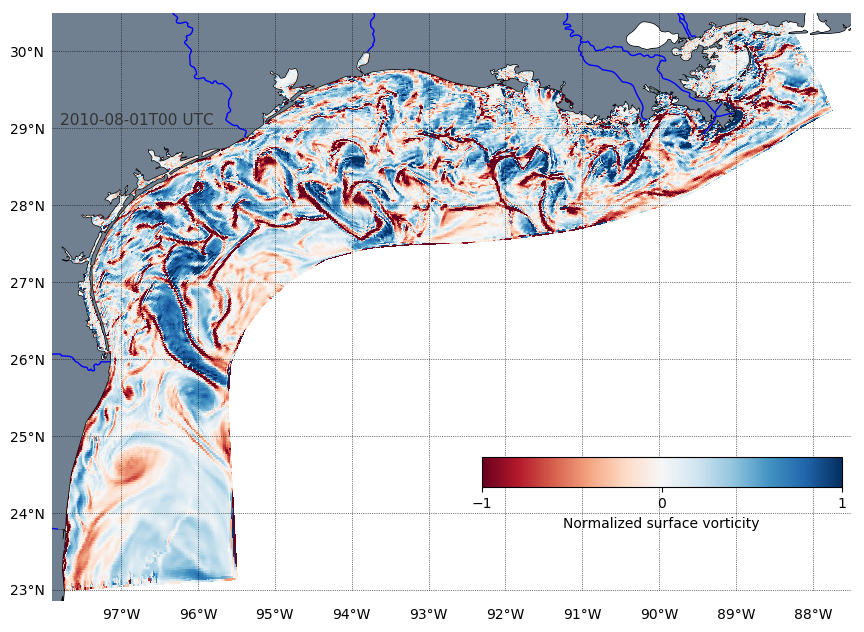

In [16]:
lon, lat = get_lonlat(vort)
fig, ax, cb = plot_map(lon, lat, vort, vmin=-1, vmax=1)
ax.text(0.01, 0.81, str(ds['ocean_time'].data)[:13] + ' UTC', fontsize=11, color='0.2', transform=ax.transAxes)
cb.set_label('Normalized surface vorticity')

In [ ]:
vort